In [1]:
from itertools import islice

import torch
from torch.nn import Linear
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import vgg16, VGG16_Weights
from tqdm import tqdm

from zennit.attribution import Gradient, SmoothGrad
from zennit.core import Stabilizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.composites import SpecialFirstLayerMapComposite, NameMapComposite
from zennit.image import imgify, imsave
from zennit.rules import Epsilon, ZPlus, ZBox, Norm, Pass, Flat
from zennit.types import Convolution, Activation, AvgPool, Linear as AnyLinear
from zennit.types import BatchNorm
from zennit.torchvision import VGGCanonizer, ResNetCanonizer

In [2]:
# load the model and set it to evaluation mode
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights).eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# define the base image transform
transform_img = Compose([
    Resize(256),
    CenterCrop(224),
])
# define the normalization transform
transform_norm = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# define the full tensor transform
transform = Compose([
    transform_img,
    ToTensor(),
    transform_norm,
])

In [4]:
target_labels = [
    0,     # tench
    217,   # English springer
    482,   # cassette player
    491,   # chain saw
    497,   # church
    566,   # French horn
    569,   # garbage truck
    571,   # gas pump
    574,   # golf ball
    701,   # parachute
]

In [5]:
# load the images
import os

imgs_list = []
labels_list = []

parent_dir = os.fsencode("../../external/imagenette2-320/val/")

error_files = []

for i, subdir in enumerate(os.listdir(parent_dir)):
    for file in os.listdir(filedir := os.path.join(parent_dir, subdir)):
        filepath = os.path.join(filedir, file)
        image = Image.open(filepath)

        try:
            # transform the PIL image and insert a batch-dimension
            img_tensor = transform(image)[None]
        except RuntimeError:
            error_files.append(filepath)
            continue

        imgs_list.append(img_tensor)
        labels_list.append(target_labels[i])


In [6]:
len(imgs_list), len(error_files)

(3856, 69)

In [7]:
data = list(zip(imgs_list, labels_list))

In [8]:
# Saliency
saliency_attrs = []

# create the attributor, specifying model
with Gradient(model=model) as attributor:
    for img_tensor, label in tqdm(data):
        target = torch.eye(1000)[[label]].to(device)
        # compute the model output and attribution
        output, attribution = attributor(img_tensor.to(device), target)

        # absolute sum over the channels
        relevance = attribution.abs().sum(1).cpu()

        saliency_attrs.append(relevance)


  0%|                                                                                         | 0/3856 [00:00<?, ?it/s]C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:24<00:00, 156.83it/s]


In [9]:
# SmoothGrad
smoothgrad_attrs = []

# create the attributor, specifying model
with SmoothGrad(noise_level=0.1, n_iter=20, model=model) as attributor:
    for img_tensor, label in tqdm(data):
        target = torch.eye(1000)[[label]].to(device)
        # compute the model output and attribution
        output, attribution = attributor(img_tensor.to(device), target)

        # absolute sum over the channels
        relevance = attribution.abs().sum(1).cpu()

        smoothgrad_attrs.append(relevance)

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [07:13<00:00,  8.90it/s]


In [10]:
# Epsilon-Gamma LRP
lrp_attrs = []

# the EpsilonGammaBox composite needs the lowest and highest values, which are
# here for ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying required arguments
composite = EpsilonGammaBox(low=low, high=high)

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    for img_tensor, label in tqdm(data):
        target = torch.eye(1000)[[label]].to(device)
        # compute the model output and attribution
        output, attribution = attributor(img_tensor.to(device), target)

        # absolute sum over the channels
        relevance = attribution.abs().sum(1).cpu()

        lrp_attrs.append(relevance)

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [02:11<00:00, 29.41it/s]


In [8]:
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [9]:
from lrp_engine import LRPEngine

In [10]:
img_tensor = data[0][0].to(device).requires_grad_()
output = model(img_tensor)

In [11]:
lrp = LRPEngine(use_gamma=True, relevance_filter=0.7, params_to_interpret=[ img_tensor ])

In [12]:
lrp_output = lrp.run(output)

In [13]:
ourlrp_attrs = []
for img_tensor, label in tqdm(data):
    # compute the model output and attribution
    output = model(img_tensor.to(device).requires_grad_())
    _, attributions = lrp.run(output)

    # absolute sum over the channels
    relevance = attributions[0].abs().sum(1).cpu()

    ourlrp_attrs.append(relevance)

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [07:15<00:00,  8.86it/s]


In [14]:
def evaluateVGG(model, nullarg1, examples, labels, **kwargs):
    pred_idxs = []
    preds = [0, 0]
    data = list(zip(examples, labels))
    for i in tqdm(range(len(examples))):
        img_tensor = examples[i]
        true_label = labels[i]
        img_tensor = img_tensor.to(device)
        # output_tensor, pred_idx = predict(vit_model, img_tensor)
        output = model(img_tensor)
        if isinstance(output, torch.Tensor):
            pred_idx = output.argmax(dim=-1)
        else:
            pred_idx = output.logits.argmax(dim=-1)
        if pred_idx == true_label:
            preds[0] += 1
        else:
            preds[1] += 1

    return None, pred_idxs, preds

In [15]:
_, _, preds0 = evaluateVGG(model, None, imgs_list, labels_list)

100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.65it/s]


In [16]:
def get_images(num_samples):
    return [ img.clone() for img, _ in data[:num_samples] ], [ i for _, i in data[:num_samples] ]

In [17]:
patch_size = 16
img_dims = 224
num_samples = len(data)
num_patches = img_dims // patch_size
assert img_dims % patch_size == 0, f"Image dimensions {img_dims} must be divisible by patch_size {patch_size}"
occlusion_step = 4

default_args = {
    "model": model,
    "patch_size": patch_size,
    "dims": img_dims,
    "occlusion_step": occlusion_step,
    "num_samples": num_samples,
    "baseline": preds0,
    "eval_fcn": evaluateVGG,
    "image_gen_fcn": get_images,
}

In [18]:
from util import run_morf_lerf_occlusion

In [20]:
from matplotlib import pyplot as plt

In [2]:
ourlrp_attrs = torch.load("ourlrp_gamma_vgg.pt")
zennitlrp_attrs = torch.load("zennitlrp.pt")

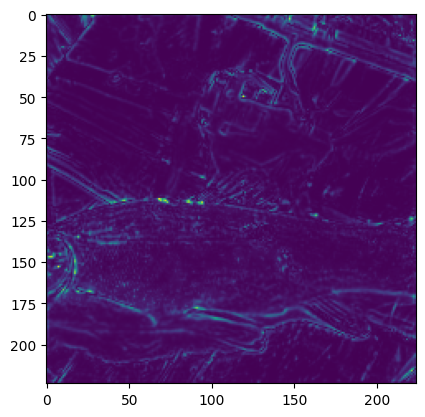

In [12]:
plt.imshow(ourlrp_attrs[0][0] / ourlrp_attrs[0].abs().max())

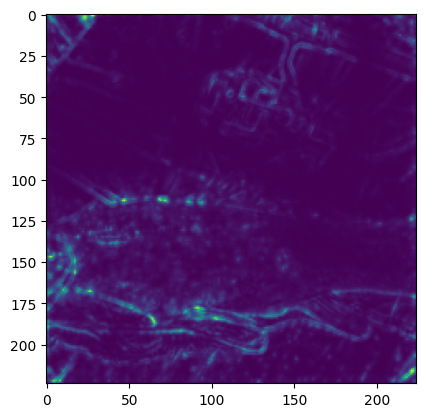

In [13]:
plt.imshow(zennitlrp_attrs[0][0] / zennitlrp_attrs[0].abs().max())

In [26]:
# ourlrp_attrs = torch.load("ourlrp_vgg.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.535425].


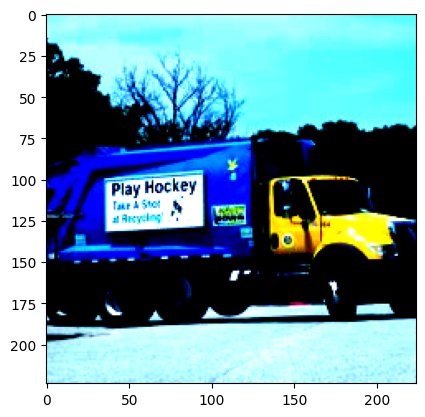

In [21]:


img_ind = 2400
plt.imshow(imgs_list[img_ind][0].permute(1,2,0))

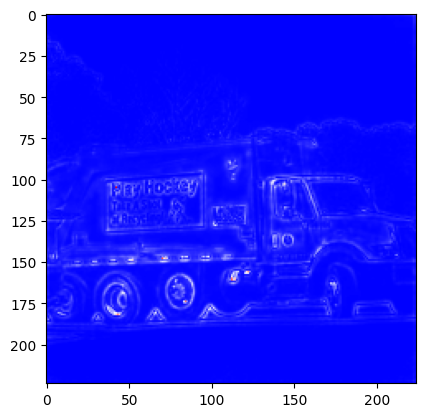

In [22]:
plt.imshow(ourlrp_attrs[img_ind][0], cmap="bwr")

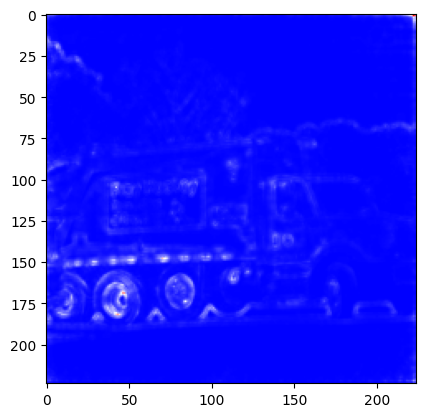

In [59]:
plt.imshow(lrp_heatmaps[img_ind][0], cmap="bwr")

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.97it/s]


0 [3100, 756]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.26it/s]


1 [3042, 814]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.77it/s]


2 [2973, 883]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.05it/s]


3 [2912, 944]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.38it/s]


4 [2847, 1009]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.32it/s]


5 [2798, 1058]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.61it/s]


6 [2741, 1115]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.14it/s]


7 [2669, 1187]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.52it/s]


8 [2623, 1233]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.26it/s]


9 [2554, 1302]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.32it/s]


10 [2499, 1357]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.67it/s]


11 [2427, 1429]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.19it/s]


12 [2364, 1492]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.09it/s]


13 [2308, 1548]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.73it/s]


14 [2256, 1600]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.46it/s]


15 [2187, 1669]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.35it/s]


16 [2138, 1718]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.91it/s]


17 [2072, 1784]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.11it/s]


18 [2011, 1845]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.98it/s]


19 [1918, 1938]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.72it/s]


20 [1854, 2002]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.75it/s]


21 [1771, 2085]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.08it/s]


22 [1708, 2148]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.79it/s]


23 [1638, 2218]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.03it/s]


24 [1555, 2301]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.88it/s]


25 [1465, 2391]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.72it/s]


26 [1369, 2487]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.32it/s]


27 [1283, 2573]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.27it/s]


28 [1197, 2659]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.94it/s]


29 [1099, 2757]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.50it/s]


30 [1019, 2837]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.95it/s]


31 [939, 2917]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.13it/s]


32 [859, 2997]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.72it/s]


33 [786, 3070]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.39it/s]


34 [700, 3156]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.71it/s]


35 [614, 3242]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.58it/s]


36 [521, 3335]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.98it/s]


37 [449, 3407]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.71it/s]


38 [366, 3490]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.02it/s]


39 [306, 3550]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.50it/s]


40 [239, 3617]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.76it/s]


41 [182, 3674]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.92it/s]


42 [134, 3722]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.77it/s]


43 [93, 3763]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.02it/s]


44 [59, 3797]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.75it/s]


45 [30, 3826]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.06it/s]


46 [18, 3838]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.89it/s]


47 [8, 3848]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.08it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.49it/s]


0 [3161, 695]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.20it/s]


1 [3122, 734]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.58it/s]


2 [3087, 769]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.80it/s]


3 [3029, 827]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.17it/s]


4 [2974, 882]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.36it/s]


5 [2905, 951]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.47it/s]


6 [2812, 1044]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.42it/s]


7 [2725, 1131]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.03it/s]


8 [2617, 1239]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.11it/s]


9 [2523, 1333]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.07it/s]


10 [2415, 1441]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.28it/s]


11 [2319, 1537]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.19it/s]


12 [2212, 1644]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.48it/s]


13 [2105, 1751]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.52it/s]


14 [2015, 1841]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.56it/s]


15 [1914, 1942]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 320.99it/s]


16 [1825, 2031]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.64it/s]


17 [1729, 2127]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.96it/s]


18 [1639, 2217]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.90it/s]


19 [1539, 2317]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.75it/s]


20 [1447, 2409]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.72it/s]


21 [1368, 2488]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.31it/s]


22 [1299, 2557]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.35it/s]


23 [1219, 2637]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.47it/s]


24 [1135, 2721]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.20it/s]


25 [1060, 2796]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 333.02it/s]


26 [993, 2863]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.76it/s]


27 [941, 2915]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.03it/s]


28 [871, 2985]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.53it/s]


29 [807, 3049]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.67it/s]


30 [743, 3113]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.50it/s]


31 [661, 3195]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.96it/s]


32 [620, 3236]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.00it/s]


33 [566, 3290]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.49it/s]


34 [493, 3363]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.27it/s]


35 [457, 3399]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.24it/s]


36 [406, 3450]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.83it/s]


37 [361, 3495]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.92it/s]


38 [329, 3527]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.14it/s]


39 [287, 3569]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.54it/s]


40 [245, 3611]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.69it/s]


41 [200, 3656]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.33it/s]


42 [159, 3697]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.46it/s]


43 [129, 3727]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.96it/s]


44 [94, 3762]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.46it/s]


45 [69, 3787]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.74it/s]


46 [40, 3816]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 341.84it/s]


47 [22, 3834]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.41it/s]


48 [5, 3851]


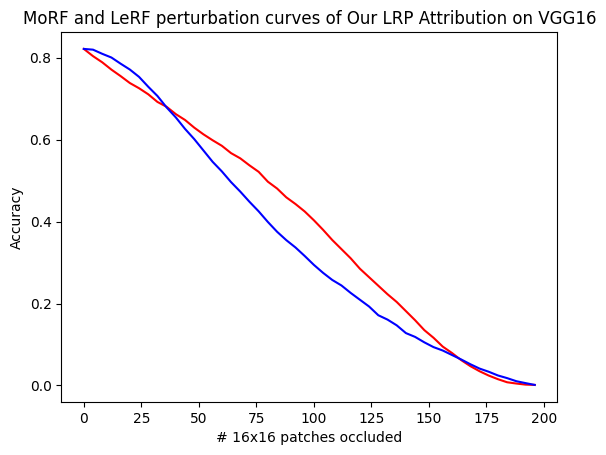

-0.14844610043187384 1.7136400203234816 1.8620861207553556


([[3100, 756],
  [3042, 814],
  [2973, 883],
  [2912, 944],
  [2847, 1009],
  [2798, 1058],
  [2741, 1115],
  [2669, 1187],
  [2623, 1233],
  [2554, 1302],
  [2499, 1357],
  [2427, 1429],
  [2364, 1492],
  [2308, 1548],
  [2256, 1600],
  [2187, 1669],
  [2138, 1718],
  [2072, 1784],
  [2011, 1845],
  [1918, 1938],
  [1854, 2002],
  [1771, 2085],
  [1708, 2148],
  [1638, 2218],
  [1555, 2301],
  [1465, 2391],
  [1369, 2487],
  [1283, 2573],
  [1197, 2659],
  [1099, 2757],
  [1019, 2837],
  [939, 2917],
  [859, 2997],
  [786, 3070],
  [700, 3156],
  [614, 3242],
  [521, 3335],
  [449, 3407],
  [366, 3490],
  [306, 3550],
  [239, 3617],
  [182, 3674],
  [134, 3722],
  [93, 3763],
  [59, 3797],
  [30, 3826],
  [18, 3838],
  [8, 3848],
  [5, 3851]],
 [[3161, 695],
  [3122, 734],
  [3087, 769],
  [3029, 827],
  [2974, 882],
  [2905, 951],
  [2812, 1044],
  [2725, 1131],
  [2617, 1239],
  [2523, 1333],
  [2415, 1441],
  [2319, 1537],
  [2212, 1644],
  [2105, 1751],
  [2015, 1841],
  [1914, 19

In [19]:
run_morf_lerf_occlusion(heatmaps=ourlrp_attrs, attr_name="Our LRP", **default_args)

In [16]:
del ourlrp_attrs

In [17]:
saliency_heatmaps = torch.load("zennitsaliency.pt")

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.27it/s]


0 [3153, 703]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.95it/s]


1 [3113, 743]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.32it/s]


2 [3074, 782]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.73it/s]


3 [3039, 817]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.00it/s]


4 [3007, 849]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.76it/s]


5 [2972, 884]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.13it/s]


6 [2931, 925]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.95it/s]


7 [2890, 966]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.12it/s]


8 [2838, 1018]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.58it/s]


9 [2787, 1069]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.44it/s]


10 [2752, 1104]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.48it/s]


11 [2688, 1168]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.26it/s]


12 [2624, 1232]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.49it/s]


13 [2559, 1297]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.56it/s]


14 [2505, 1351]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.59it/s]


15 [2447, 1409]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.99it/s]


16 [2388, 1468]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.95it/s]


17 [2327, 1529]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.52it/s]


18 [2270, 1586]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.86it/s]


19 [2211, 1645]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.73it/s]


20 [2140, 1716]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 336.32it/s]


21 [2060, 1796]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.33it/s]


22 [1994, 1862]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 340.55it/s]


23 [1935, 1921]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.36it/s]


24 [1881, 1975]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.29it/s]


25 [1810, 2046]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.35it/s]


26 [1739, 2117]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 335.85it/s]


27 [1680, 2176]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.98it/s]


28 [1601, 2255]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 339.84it/s]


29 [1517, 2339]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.41it/s]


30 [1442, 2414]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.75it/s]


31 [1357, 2499]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.25it/s]


32 [1259, 2597]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.88it/s]


33 [1171, 2685]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.13it/s]


34 [1068, 2788]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.99it/s]


35 [979, 2877]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 337.71it/s]


36 [876, 2980]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.52it/s]


37 [796, 3060]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.59it/s]


38 [724, 3132]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.79it/s]


39 [637, 3219]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.69it/s]


40 [548, 3308]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.01it/s]


41 [485, 3371]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.03it/s]


42 [396, 3460]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.52it/s]


43 [309, 3547]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.47it/s]


44 [223, 3633]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.21it/s]


45 [150, 3706]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.52it/s]


46 [90, 3766]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.65it/s]


47 [35, 3821]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.32it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.92it/s]


0 [3037, 819]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.04it/s]


1 [2900, 956]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.52it/s]


2 [2757, 1099]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.92it/s]


3 [2648, 1208]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.78it/s]


4 [2544, 1312]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.03it/s]


5 [2398, 1458]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.34it/s]


6 [2288, 1568]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.29it/s]


7 [2188, 1668]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.01it/s]


8 [2082, 1774]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.11it/s]


9 [2005, 1851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.59it/s]


10 [1913, 1943]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.64it/s]


11 [1809, 2047]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.58it/s]


12 [1726, 2130]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.29it/s]


13 [1657, 2199]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.77it/s]


14 [1567, 2289]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.52it/s]


15 [1490, 2366]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.30it/s]


16 [1404, 2452]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.72it/s]


17 [1321, 2535]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.53it/s]


18 [1246, 2610]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.62it/s]


19 [1172, 2684]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.07it/s]


20 [1115, 2741]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.55it/s]


21 [1056, 2800]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.41it/s]


22 [986, 2870]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.81it/s]


23 [918, 2938]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.44it/s]


24 [861, 2995]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.69it/s]


25 [791, 3065]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.33it/s]


26 [740, 3116]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.29it/s]


27 [683, 3173]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.16it/s]


28 [635, 3221]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.99it/s]


29 [578, 3278]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.69it/s]


30 [533, 3323]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.58it/s]


31 [490, 3366]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.02it/s]


32 [458, 3398]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.63it/s]


33 [416, 3440]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.52it/s]


34 [379, 3477]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.54it/s]


35 [349, 3507]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.27it/s]


36 [312, 3544]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.66it/s]


37 [281, 3575]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.79it/s]


38 [253, 3603]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.84it/s]


39 [220, 3636]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.08it/s]


40 [175, 3681]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.89it/s]


41 [142, 3714]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.62it/s]


42 [115, 3741]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.21it/s]


43 [95, 3761]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.38it/s]


44 [69, 3787]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.46it/s]


45 [51, 3805]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.43it/s]


46 [29, 3827]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.98it/s]


47 [19, 3837]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.16it/s]


48 [5, 3851]


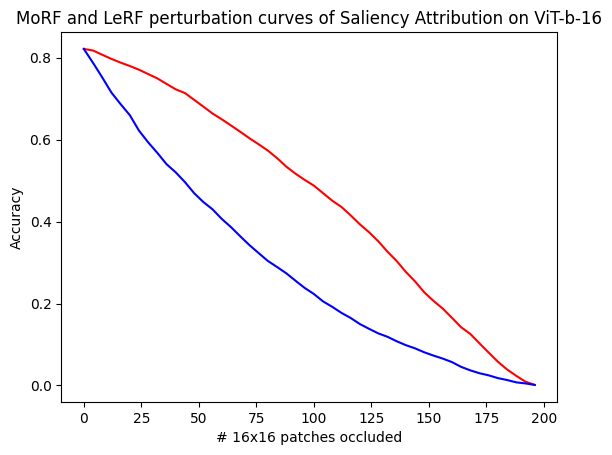

-0.6896434922516724 1.4431471758828005 2.1327906681344726


([[3153, 703],
  [3113, 743],
  [3074, 782],
  [3039, 817],
  [3007, 849],
  [2972, 884],
  [2931, 925],
  [2890, 966],
  [2838, 1018],
  [2787, 1069],
  [2752, 1104],
  [2688, 1168],
  [2624, 1232],
  [2559, 1297],
  [2505, 1351],
  [2447, 1409],
  [2388, 1468],
  [2327, 1529],
  [2270, 1586],
  [2211, 1645],
  [2140, 1716],
  [2060, 1796],
  [1994, 1862],
  [1935, 1921],
  [1881, 1975],
  [1810, 2046],
  [1739, 2117],
  [1680, 2176],
  [1601, 2255],
  [1517, 2339],
  [1442, 2414],
  [1357, 2499],
  [1259, 2597],
  [1171, 2685],
  [1068, 2788],
  [979, 2877],
  [876, 2980],
  [796, 3060],
  [724, 3132],
  [637, 3219],
  [548, 3308],
  [485, 3371],
  [396, 3460],
  [309, 3547],
  [223, 3633],
  [150, 3706],
  [90, 3766],
  [35, 3821],
  [5, 3851]],
 [[3037, 819],
  [2900, 956],
  [2757, 1099],
  [2648, 1208],
  [2544, 1312],
  [2398, 1458],
  [2288, 1568],
  [2188, 1668],
  [2082, 1774],
  [2005, 1851],
  [1913, 1943],
  [1809, 2047],
  [1726, 2130],
  [1657, 2199],
  [1567, 2289],
  [

In [18]:
run_morf_lerf_occlusion(heatmaps=saliency_heatmaps, attr_name="Saliency", **default_args)

In [19]:
del saliency_heatmaps

In [20]:
smoothgrad_heatmaps = torch.load("zennitsmoothgrad.pt")

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 334.61it/s]


0 [3134, 722]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.45it/s]


1 [3095, 761]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.01it/s]


2 [3063, 793]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.53it/s]


3 [3017, 839]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.34it/s]


4 [2980, 876]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.40it/s]


5 [2934, 922]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 342.01it/s]


6 [2891, 965]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.27it/s]


7 [2835, 1021]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.99it/s]


8 [2800, 1056]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.08it/s]


9 [2760, 1096]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 343.98it/s]


10 [2703, 1153]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.30it/s]


11 [2671, 1185]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 338.07it/s]


12 [2612, 1244]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.98it/s]


13 [2560, 1296]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.94it/s]


14 [2502, 1354]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.33it/s]


15 [2428, 1428]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.38it/s]


16 [2361, 1495]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.79it/s]


17 [2295, 1561]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.76it/s]


18 [2238, 1618]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.65it/s]


19 [2170, 1686]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.88it/s]


20 [2128, 1728]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.06it/s]


21 [2065, 1791]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.35it/s]


22 [1993, 1863]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.34it/s]


23 [1928, 1928]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.73it/s]


24 [1859, 1997]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.33it/s]


25 [1791, 2065]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.74it/s]


26 [1704, 2152]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.53it/s]


27 [1614, 2242]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.68it/s]


28 [1523, 2333]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.76it/s]


29 [1427, 2429]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.37it/s]


30 [1324, 2532]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.48it/s]


31 [1255, 2601]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.83it/s]


32 [1177, 2679]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.84it/s]


33 [1082, 2774]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.93it/s]


34 [995, 2861]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.61it/s]


35 [918, 2938]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.89it/s]


36 [818, 3038]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.03it/s]


37 [736, 3120]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.72it/s]


38 [643, 3213]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.42it/s]


39 [557, 3299]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.93it/s]


40 [466, 3390]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.76it/s]


41 [379, 3477]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.87it/s]


42 [293, 3563]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.59it/s]


43 [206, 3650]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.74it/s]


44 [147, 3709]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.17it/s]


45 [90, 3766]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.90it/s]


46 [51, 3805]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.36it/s]


47 [21, 3835]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.10it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.67it/s]


0 [3078, 778]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.40it/s]


1 [2986, 870]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.28it/s]


2 [2880, 976]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.72it/s]


3 [2780, 1076]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.15it/s]


4 [2673, 1183]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.12it/s]


5 [2574, 1282]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.55it/s]


6 [2478, 1378]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.30it/s]


7 [2364, 1492]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.86it/s]


8 [2274, 1582]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 344.45it/s]


9 [2191, 1665]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.92it/s]


10 [2083, 1773]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.81it/s]


11 [1983, 1873]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.04it/s]


12 [1895, 1961]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.31it/s]


13 [1803, 2053]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.26it/s]


14 [1701, 2155]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.64it/s]


15 [1609, 2247]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.79it/s]


16 [1534, 2322]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.19it/s]


17 [1430, 2426]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.76it/s]


18 [1342, 2514]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.18it/s]


19 [1262, 2594]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.12it/s]


20 [1187, 2669]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.84it/s]


21 [1130, 2726]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.89it/s]


22 [1043, 2813]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.55it/s]


23 [983, 2873]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.53it/s]


24 [932, 2924]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.88it/s]


25 [862, 2994]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.37it/s]


26 [805, 3051]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 345.78it/s]


27 [728, 3128]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.43it/s]


28 [674, 3182]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.22it/s]


29 [631, 3225]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.80it/s]


30 [580, 3276]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.91it/s]


31 [530, 3326]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.04it/s]


32 [485, 3371]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.79it/s]


33 [423, 3433]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.02it/s]


34 [373, 3483]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.50it/s]


35 [333, 3523]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.46it/s]


36 [286, 3570]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.14it/s]


37 [253, 3603]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.45it/s]


38 [221, 3635]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.62it/s]


39 [193, 3663]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.25it/s]


40 [169, 3687]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.77it/s]


41 [130, 3726]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.56it/s]


42 [103, 3753]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 348.52it/s]


43 [84, 3772]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.55it/s]


44 [61, 3795]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.29it/s]


45 [45, 3811]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 346.81it/s]


46 [30, 3826]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 349.03it/s]


47 [21, 3835]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 347.71it/s]

48 [5, 3851]


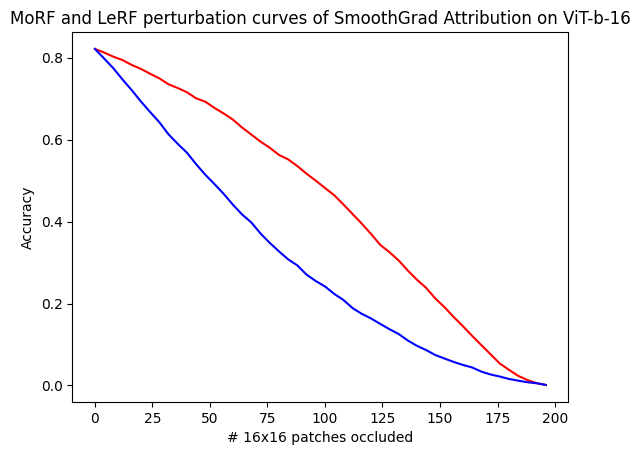

-0.5721060208315693 1.4905262935049532 2.0626323143365224


([[3134, 722],
  [3095, 761],
  [3063, 793],
  [3017, 839],
  [2980, 876],
  [2934, 922],
  [2891, 965],
  [2835, 1021],
  [2800, 1056],
  [2760, 1096],
  [2703, 1153],
  [2671, 1185],
  [2612, 1244],
  [2560, 1296],
  [2502, 1354],
  [2428, 1428],
  [2361, 1495],
  [2295, 1561],
  [2238, 1618],
  [2170, 1686],
  [2128, 1728],
  [2065, 1791],
  [1993, 1863],
  [1928, 1928],
  [1859, 1997],
  [1791, 2065],
  [1704, 2152],
  [1614, 2242],
  [1523, 2333],
  [1427, 2429],
  [1324, 2532],
  [1255, 2601],
  [1177, 2679],
  [1082, 2774],
  [995, 2861],
  [918, 2938],
  [818, 3038],
  [736, 3120],
  [643, 3213],
  [557, 3299],
  [466, 3390],
  [379, 3477],
  [293, 3563],
  [206, 3650],
  [147, 3709],
  [90, 3766],
  [51, 3805],
  [21, 3835],
  [5, 3851]],
 [[3078, 778],
  [2986, 870],
  [2880, 976],
  [2780, 1076],
  [2673, 1183],
  [2574, 1282],
  [2478, 1378],
  [2364, 1492],
  [2274, 1582],
  [2191, 1665],
  [2083, 1773],
  [1983, 1873],
  [1895, 1961],
  [1803, 2053],
  [1701, 2155],
  [16

In [21]:
run_morf_lerf_occlusion(heatmaps=smoothgrad_heatmaps, attr_name="SmoothGrad", **default_args)

In [22]:
del smoothgrad_heatmaps

In [27]:
lrp_heatmaps = torch.load("zennitlrp.pt")

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [3168, 688]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:14<00:00, 264.73it/s]


0 [3055, 801]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 318.65it/s]


1 [2957, 899]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:12<00:00, 319.07it/s]


2 [2877, 979]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.70it/s]


3 [2805, 1051]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.76it/s]


4 [2761, 1095]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.88it/s]


5 [2672, 1184]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.39it/s]


6 [2600, 1256]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.53it/s]


7 [2503, 1353]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.29it/s]


8 [2406, 1450]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.58it/s]


9 [2308, 1548]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.52it/s]


10 [2215, 1641]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.84it/s]


11 [2115, 1741]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.88it/s]


12 [2021, 1835]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.94it/s]


13 [1919, 1937]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.05it/s]


14 [1840, 2016]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.79it/s]


15 [1744, 2112]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.90it/s]


16 [1642, 2214]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.86it/s]


17 [1563, 2293]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.21it/s]


18 [1468, 2388]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.44it/s]


19 [1366, 2490]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.08it/s]


20 [1284, 2572]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.47it/s]


21 [1191, 2665]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.68it/s]


22 [1105, 2751]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.29it/s]


23 [1019, 2837]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.81it/s]


24 [944, 2912]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.10it/s]


25 [874, 2982]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.02it/s]


26 [775, 3081]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.89it/s]


27 [703, 3153]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.02it/s]


28 [639, 3217]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.05it/s]


29 [565, 3291]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.88it/s]


30 [500, 3356]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.20it/s]


31 [430, 3426]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.95it/s]


32 [383, 3473]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.13it/s]


33 [341, 3515]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.34it/s]


34 [303, 3553]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.42it/s]


35 [255, 3601]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.40it/s]


36 [211, 3645]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.50it/s]


37 [180, 3676]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.31it/s]


38 [147, 3709]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.86it/s]


39 [118, 3738]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.97it/s]


40 [98, 3758]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.81it/s]


41 [78, 3778]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.36it/s]


42 [46, 3810]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.79it/s]


43 [33, 3823]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.33it/s]


44 [25, 3831]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.24it/s]


45 [14, 3842]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.52it/s]


46 [10, 3846]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.54it/s]


47 [7, 3849]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.09it/s]


48 [5, 3851]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.86it/s]


0 [3154, 702]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.39it/s]


1 [3128, 728]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.12it/s]


2 [3110, 746]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.54it/s]


3 [3090, 766]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.23it/s]


4 [3046, 810]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.12it/s]


5 [3014, 842]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.25it/s]


6 [2976, 880]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 324.83it/s]


7 [2938, 918]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.42it/s]


8 [2887, 969]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.95it/s]


9 [2832, 1024]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.57it/s]


10 [2779, 1077]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.68it/s]


11 [2716, 1140]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.32it/s]


12 [2671, 1185]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.26it/s]


13 [2615, 1241]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.92it/s]


14 [2535, 1321]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.39it/s]


15 [2470, 1386]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.45it/s]


16 [2368, 1488]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.46it/s]


17 [2294, 1562]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.27it/s]


18 [2211, 1645]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 328.15it/s]


19 [2108, 1748]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.44it/s]


20 [2023, 1833]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.85it/s]


21 [1935, 1921]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 326.41it/s]


22 [1840, 2016]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 325.51it/s]


23 [1749, 2107]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.22it/s]


24 [1658, 2198]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 327.33it/s]


25 [1570, 2286]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 322.37it/s]


26 [1466, 2390]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.92it/s]


27 [1390, 2466]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.62it/s]


28 [1296, 2560]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.58it/s]


29 [1222, 2634]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.20it/s]


30 [1125, 2731]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.02it/s]


31 [1040, 2816]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.11it/s]


32 [954, 2902]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.14it/s]


33 [858, 2998]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.65it/s]


34 [786, 3070]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 332.06it/s]


35 [713, 3143]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.93it/s]


36 [648, 3208]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.50it/s]


37 [578, 3278]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.68it/s]


38 [517, 3339]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.78it/s]


39 [474, 3382]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.58it/s]


40 [409, 3447]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.14it/s]


41 [347, 3509]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.07it/s]


42 [289, 3567]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.05it/s]


43 [236, 3620]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 329.84it/s]


44 [207, 3649]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 330.33it/s]


45 [158, 3698]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.60it/s]


46 [121, 3735]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.63it/s]


47 [62, 3794]


100%|█████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:11<00:00, 331.16it/s]


48 [5, 3851]


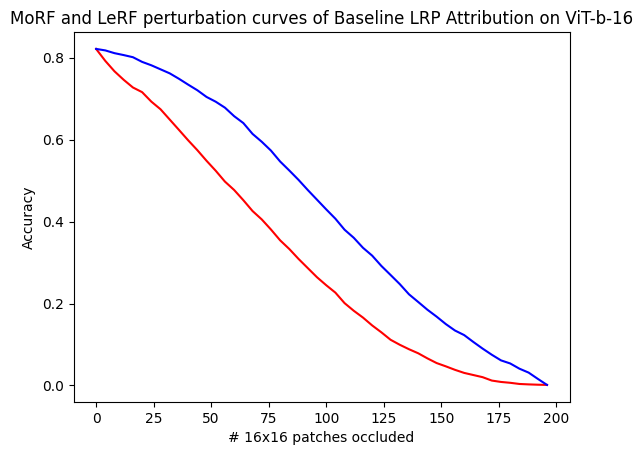

0.4974595647387586 2.043579049877212 1.5461194851384532


([[3055, 801],
  [2957, 899],
  [2877, 979],
  [2805, 1051],
  [2761, 1095],
  [2672, 1184],
  [2600, 1256],
  [2503, 1353],
  [2406, 1450],
  [2308, 1548],
  [2215, 1641],
  [2115, 1741],
  [2021, 1835],
  [1919, 1937],
  [1840, 2016],
  [1744, 2112],
  [1642, 2214],
  [1563, 2293],
  [1468, 2388],
  [1366, 2490],
  [1284, 2572],
  [1191, 2665],
  [1105, 2751],
  [1019, 2837],
  [944, 2912],
  [874, 2982],
  [775, 3081],
  [703, 3153],
  [639, 3217],
  [565, 3291],
  [500, 3356],
  [430, 3426],
  [383, 3473],
  [341, 3515],
  [303, 3553],
  [255, 3601],
  [211, 3645],
  [180, 3676],
  [147, 3709],
  [118, 3738],
  [98, 3758],
  [78, 3778],
  [46, 3810],
  [33, 3823],
  [25, 3831],
  [14, 3842],
  [10, 3846],
  [7, 3849],
  [5, 3851]],
 [[3154, 702],
  [3128, 728],
  [3110, 746],
  [3090, 766],
  [3046, 810],
  [3014, 842],
  [2976, 880],
  [2938, 918],
  [2887, 969],
  [2832, 1024],
  [2779, 1077],
  [2716, 1140],
  [2671, 1185],
  [2615, 1241],
  [2535, 1321],
  [2470, 1386],
  [2368

In [24]:
run_morf_lerf_occlusion(heatmaps=lrp_heatmaps, attr_name="Baseline LRP", **default_args)

In [25]:
del lrp_heatmaps